# Import required libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Define Functions

# Define classes

## Class: Poly_Feature

In [2]:
class Poly_Feature(object):

    def __init__(self, degree = 9):
        self.M = degree


    def transform(self, X:np.ndarray):
        if X.ndim == 1:
            X = X[:, None]
        pows = np.repeat(np.arange(1, self.M + 1), X.shape[1])
        PHI = np.tile(X, self.M) ** pows
        ones_mat = np.ones(X.shape[0]).reshape(-1, 1)
        return np.concatenate([ones_mat, PHI], axis=1)

## Class: Bayesian_Regression

In [27]:
class Bayesian_Regression(object):
    
    '''
    Bayesian Regression Class
    '''

    def __init__(self, alpha:float = 0.005, beta:float = 11):
        '''
        Arguments:
            alpha: Precision parameter governing prior distribution of w vector (Ref. Eqn: 3.52, Pg. 153 of PRML)
            beta: Noise variance of Gaussian noise in training set (Ref. Eqn: 3.8, Pg. 140 of PRML)
        '''
        
        self.alpha = alpha
        self.beta = beta
        self.w_mean = None # Posterior mean of weight vector distribution
        self.w_cov = None # Posterior covariance of weight vector distribution
        self.w_precision = None # Posterior precision of weight vector distribution
        
    def _is_prior_defined(self) -> bool:
        return self.w_mean is not None and self.w_precision is not None
    
    def _get_prior(self, ndim:int) -> tuple:
        if self._is_prior_defined():
            return self.w_mean, self.w_precision
        else:
            return np.zeros(ndim), self.alpha * np.eye(ndim) 
        
    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        Bayesian update of parameters given training dataset

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
        """

        mean_prev, precision_prev = self._get_prior(np.size(X, 1))

        w_precision = precision_prev + self.beta * X.T @ X
        w_mean = np.linalg.solve(w_precision, precision_prev @ mean_prev + self.beta * X.T @ t)
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(self.w_precision)        
        
    def predict(self, X:np.ndarray, return_std:bool = False, sample_size:int = None):
        """
        return mean (and standard deviation) of predictive distribution

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            independent variable
        return_std : bool, optional
            flag to return standard deviation (the default is False)
        sample_size : int, optional
            number of samples to draw from the predictive distribution
            (the default is None, no sampling from the distribution)

        Returns
        -------
        y : (N,) np.ndarray
            mean of the predictive distribution
        y_std : (N,) np.ndarray
            standard deviation of the predictive distribution
        y_sample : (N, sample_size) np.ndarray
            samples from the predictive distribution
        """

        if sample_size is not None:
            w_sample = np.random.multivariate_normal(self.w_mean, self.w_cov, size = sample_size)
            y_sample = X @ w_sample.T
            return y_sample
        y = X @ self.w_mean
        if return_std:
            y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=1)
            y_std = np.sqrt(y_var)
            return y, y_std
        return y


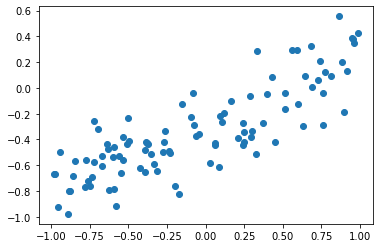

In [38]:
feature = Poly_Feature(1) # Polynomial feature generation object with bias and first-order term

# Generate training set
std_train_data = 0.2 # Standard-Deviation of Gaussian noise on training set
x_train = np.random.uniform(-1, 1, 100) # Training set inputs
t_train = (-0.3 + 0.5 * x_train) + np.random.normal(scale = std_train_data, size = x_train.shape) # Training set outputs

X_train = feature.transform(x_train) # Obtain design matrix

x_test = np.linspace(-1, 1, 100)
X_test = feature.transform(x_test) # Feature transform test set input

# Obtain weight matrix over which prior and posterior distributions will be evaluated
wx, wy = np.meshgrid(x_test, x_test)
W = np.array([wx, wy]).reshape(2, -1).T



plt.scatter(x_train, t_train);

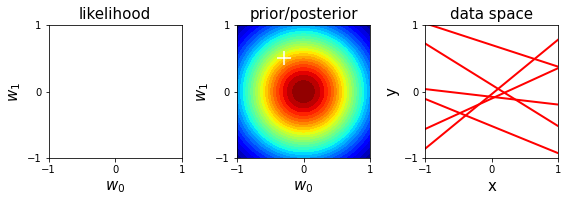

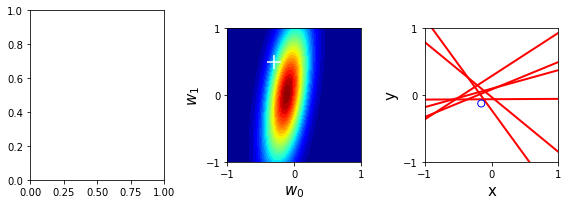

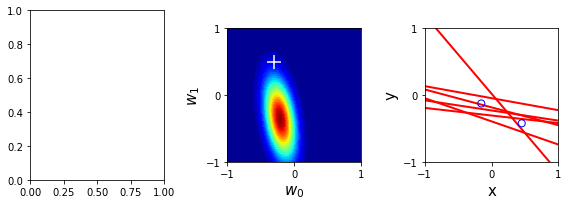

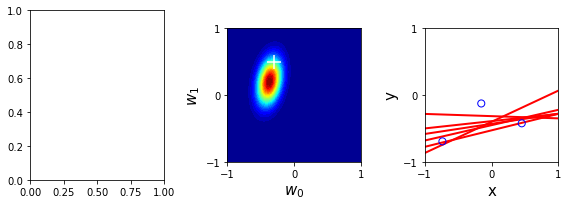

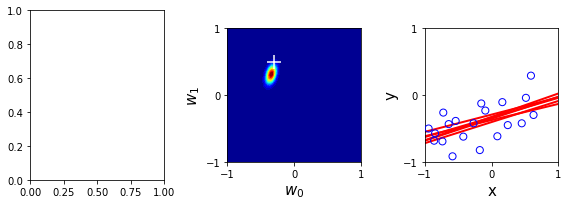

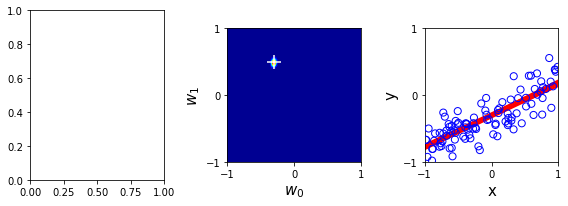

In [40]:
model = Bayesian_Regression(alpha = 2, beta = 25) # Define Bayesian Regression object
for n, (begin, end) in enumerate([[0, 0], [0, 1], [1, 2], [2, 3], [3, 20], [21, 100]], 1):

    model.fit(X_train[begin:end], t_train[begin:end])

    fig = plt.figure(figsize = (8, 3))

    # Likelihood plots
    ax = fig.add_subplot(1, 3, 1) 
    if n == 1:
        ax.set_title("likelihood", fontsize = 15)
        plt.gca().set_aspect('equal')
        plt.xticks([-1, 0, 1])
        plt.yticks([-1, 0, 1])
        plt.xlabel("$w_0$", fontsize = 15)
        plt.ylabel("$w_1$", fontsize = 15)        
#     else:
#         ax.scatter(-0.3, 0.5, s=200, marker="+", color='w', zorder=2)
#         wz = likelihood(X_train[begin:begin+1], train_y[begin:begin+1])
#         ax.contourf(wx, wy, wz.reshape(wx.shape), 30, cmap='jet')
#         plt.gca().set_aspect('equal')
#         plt.xticks([-1,0,1])
#         plt.yticks([-1,0,1])
#         plt.xlabel("$w_0$", fontsize=15)
#         plt.ylabel("$w_1$", fontsize=15)

    # Prior / Posterior Distribution Contours
    ax = fig.add_subplot(1, 3, 2)
    ax.scatter(-0.3, 0.5, s = 200, marker = "+", zorder = 2, color = 'w')
    wz = multivariate_normal(mean = model.w_mean, cov = model.w_cov).pdf(W)
    ax.contourf(wx, wy, wz.reshape(wx.shape), levels = 30, cmap = 'jet')
    plt.gca().set_aspect('equal')
    plt.xticks([-1, 0, 1])
    plt.yticks([-1, 0, 1])
    plt.xlabel("$w_0$", fontsize = 15)
    plt.ylabel("$w_1$", fontsize = 15)
    if n == 1:
        plt.title("prior/posterior", fontsize=15)

    # Data Space Plots
    ax = fig.add_subplot(1, 3, 3)
    ax.scatter(x_train[:end], t_train[:end], s = 50, facecolor = "none", edgecolor = "b", lw = 1, zorder = 3)
    ax.plot(x_test, model.predict(X_test, sample_size = 6), c = "r", lw = 2)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    plt.xticks([-1, 0, 1])
    plt.yticks([-1, 0, 1])
    plt.xlabel("x", fontsize = 15)
    plt.ylabel("y", fontsize = 15)    
    plt.gca().set_aspect('equal', adjustable = 'box')
    if n == 1:
        plt.title("data space", fontsize=15)

    plt.tight_layout()
    plt.show()

# Backup

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm

In [ ]:
    wz = multivariate_normal(mean=model.w_mean, cov=model.w_cov).pdf(W)
    ax.contourf(wx, wy, wz.reshape(wx.shape), levels=30, cmap='jet')

In [7]:
def generate_noise_data(func, noise_NUM, std_dev):
    x_n = np.linspace(-.9, .9, noise_NUM)
    np.random.shuffle(x_n)
    t_n = func(x_n) + np.random.normal(scale=std_dev,size=noise_NUM)
    return x_n, t_n

def likelihood(x, t):
    return norm(np.dot(W, x.T), np.sqrt(1 / model.beta)).pdf(t)

[0. 0.] [[0.5 0. ]
 [0.  0.5]]


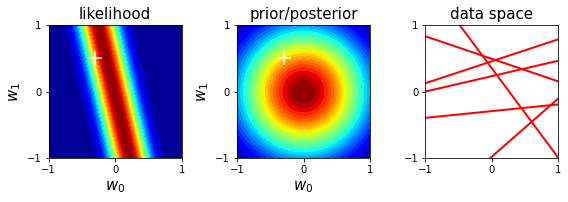

[-0.0140191  -0.00332031] [[ 0.05989564 -0.10423524]
 [-0.10423524  0.47531271]]


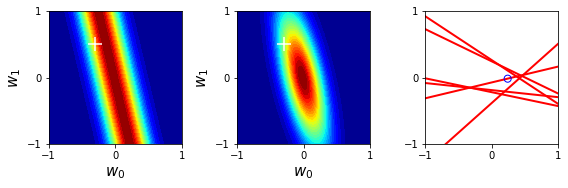

[-0.21483209  0.61542719] [[0.021256   0.01482171]
 [0.01482171 0.10847293]]


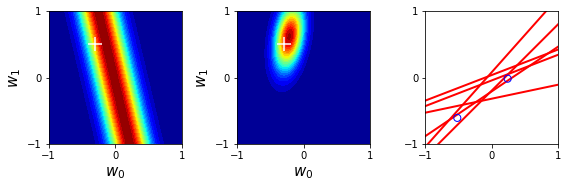

[-0.28822769  0.63543872] [[ 0.00221412 -0.00011   ]
 [-0.00011     0.00699746]]


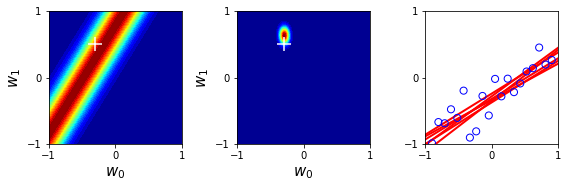

In [91]:
# Create the training data
train_x, train_y = generate_noise_data(lambda x: .5 * x - .3, 20, 0.2)
feature = Poly_Feature(1)
X_train = feature.transform(train_x)

# Create the test data
x = np.linspace(-1, 1, 100)
wx, wy = np.meshgrid(x, x)
W = np.array([wx, wy]).reshape(2, -1).T
X_test = feature.transform(x)



'''----Bayesian Regression----'''
model = Bayesian_Regression(alpha=2, beta=25)



for n, (begin, end) in enumerate([[0, 0], [0, 1], [0, 2], [2, 20]],1):
    model.fit(X_train[begin: end], train_y[begin: end])
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(1,3,1)
    ax.scatter(-0.3, 0.5, s=200, marker="+", color='w', zorder=2)
    wz = likelihood(X_train[begin:begin+1], train_y[begin:begin+1])
    ax.contourf(wx, wy, wz.reshape(wx.shape), 30, cmap='jet')
    plt.gca().set_aspect('equal')
    plt.xticks([-1,0,1])
    plt.yticks([-1,0,1])
    plt.xlabel("$w_0$", fontsize=15)
    plt.ylabel("$w_1$", fontsize=15)
    if n==1:
        ax.set_title("likelihood", fontsize=15)


    ax = fig.add_subplot(132)
    ax.scatter(-0.3, 0.5, s=200, marker="+", zorder=2, color='w')
    print(model.w_mean, model.w_cov)
    wz = multivariate_normal(mean=model.w_mean, cov=model.w_cov).pdf(W)
    ax.contourf(wx, wy, wz.reshape(wx.shape), levels=30, cmap='jet')
    plt.gca().set_aspect('equal')
    plt.xticks([-1,0,1])
    plt.yticks([-1,0,1])
    plt.xlabel("$w_0$", fontsize=15)
    plt.ylabel("$w_1$", fontsize=15)
    if n==1:
        plt.title("prior/posterior", fontsize=15)



    ax = fig.add_subplot(133)
    ax.scatter(train_x[:end], train_y[:end], s=50, facecolor="none", edgecolor="b", lw=1, zorder=3)
    ax.plot(x, model.posterior(X_test, n_sample=6), c="r", lw=2)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    plt.xticks([-1,0,1])
    plt.yticks([-1,0,1])
    plt.gca().set_aspect('equal', adjustable='box')
    if n==1:
        plt.title("data space", fontsize=15)
    plt.tight_layout()
    plt.show()

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from fitting.bayesian_regression import Bayesian_Regression
from base_module import Poly_Feature
from scipy.stats import multivariate_normal, norm

def generate_noise_data(func, noise_NUM, std_dev):
    x_n = np.linspace(-.9, .9, noise_NUM)
    np.random.shuffle(x_n)
    t_n = func(x_n) + np.random.normal(scale=std_dev,size=noise_NUM)
    return x_n, t_n

def likelihood(x, t):
    return norm(np.dot(W, x.T), np.sqrt(1 / model.beta)).pdf(t)

# Create the training data
train_x, train_y = generate_noise_data(lambda x: .5 * x - .3, 20, 0.2)
feature = Poly_Feature(1)
X_train = feature.transform(train_x)

# Create the test data
x = np.linspace(-1, 1, 100)
wx, wy = np.meshgrid(x, x)
W = np.array([wx, wy]).reshape(2, -1).T
X_test = feature.transform(x)



'''----Bayesian Regression----'''
model = Bayesian_Regression(alpha=2, beta=25)



for n, (begin, end) in enumerate([[0, 0], [0, 1], [1, 2], [2, 20]],1):
    model.fit(X_train[begin: end], train_y[begin: end])
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(1,3,1)
    ax.scatter(-0.3, 0.5, s=200, marker="+", color='w', zorder=2)
    wz = likelihood(X_train[begin:begin+1], train_y[begin:begin+1])
    ax.contourf(wx, wy, wz.reshape(wx.shape), 30, cmap='jet')
    plt.gca().set_aspect('equal')
    plt.xticks([-1,0,1])
    plt.yticks([-1,0,1])
    plt.xlabel("$w_0$", fontsize=15)
    plt.ylabel("$w_1$", fontsize=15)
    if n==1:
        ax.set_title("likelihood", fontsize=15)


    ax = fig.add_subplot(132)
    ax.scatter(-0.3, 0.5, s=200, marker="+", zorder=2, color='w')
    wz = multivariate_normal(mean=model.w_mean, cov=model.w_cov).pdf(W)
    ax.contourf(wx, wy, wz.reshape(wx.shape), levels=30, cmap='jet')
    plt.gca().set_aspect('equal')
    plt.xticks([-1,0,1])
    plt.yticks([-1,0,1])
    plt.xlabel("$w_0$", fontsize=15)
    plt.ylabel("$w_1$", fontsize=15)
    if n==1:
        plt.title("prior/posterior", fontsize=15)



    ax = fig.add_subplot(133)
    ax.scatter(train_x[:end], train_y[:end], s=50, facecolor="none", edgecolor="b", lw=1, zorder=3)
    ax.plot(x, model.posterior(X_test, n_sample=6), c="r", lw=2)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    plt.xticks([-1,0,1])
    plt.yticks([-1,0,1])
    plt.gca().set_aspect('equal', adjustable='box')
    if n==1:
        plt.title("data space", fontsize=15)
    plt.tight_layout()
    plt.show()


ModuleNotFoundError: No module named 'fitting'